In [26]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pylab as plt
import geopandas as gpd

In [169]:
demo = pd.read_csv('CD_demographic.csv')
boro_2id = {'Manhattan':1, 'Bronx':2, 'Brooklyn':3, 'Queens':4, 'Staten Island':5}
boro_id = []
for boro in demo.Borough:
    if boro in boro_2id.keys():
        boro_id.append(str(boro_2id[boro]))

cd_num = []
for num in demo['CD Number']:
    num = "{:02d}".format(num)
    cd_num.append(num)
demo['CD_Num_New'] = cd_num
demo['Borough_id'] = boro_id
demo['CommBd'] = demo.Borough_id + demo.CD_Num_New

In [170]:
Month_Tonnage=pd.read_csv("DSNY_Monthly_Tonnage_Data.csv")
Tonnage=Month_Tonnage.fillna(0).copy()
Tonnage['COMMUNITYDISTRICT'] = Tonnage.COMMUNITYDISTRICT.map('{:02}'.format)
Tonnage['MONTH']=pd.to_datetime(Tonnage['MONTH'])
Tonnage['COMMUNITYDISTRICT']=Tonnage['COMMUNITYDISTRICT'].astype(str)
Tonnage['BOROUGH_ID']=Tonnage['BOROUGH_ID'].astype(str)
Tonnage['CommBd'] = Tonnage['BOROUGH_ID']+Tonnage['COMMUNITYDISTRICT']
y15_pan = Tonnage[(Tonnage.MONTH >=datetime.date(year=2015,month=3,day=1))&(Tonnage.MONTH < datetime.date(year=2015,month=5,day=1))].groupby('CommBd')[['REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED','RESORGANICSTONS']].sum()

y16_pan = Tonnage[(Tonnage.MONTH >=datetime.date(year=2016,month=3,day=1))&(Tonnage.MONTH < datetime.date(year=2016,month=5,day=1))].groupby('CommBd')[['REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED','RESORGANICSTONS']].sum()

y17_pan = Tonnage[(Tonnage.MONTH >=datetime.date(year=2017,month=3,day=1))&(Tonnage.MONTH < datetime.date(year=2017,month=5,day=1))].groupby('CommBd')[['REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED','RESORGANICSTONS']].sum()

y18_pan = Tonnage[(Tonnage.MONTH >=datetime.date(year=2018,month=3,day=1))&(Tonnage.MONTH < datetime.date(year=2018,month=5,day=1))].groupby('CommBd')[['REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED','RESORGANICSTONS']].sum()

y19_pan = Tonnage[(Tonnage.MONTH >=datetime.date(year=2019,month=3,day=1))&(Tonnage.MONTH < datetime.date(year=2019,month=5,day=1))].groupby('CommBd')[['REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED','RESORGANICSTONS']].sum()

y20_pan = Tonnage[(Tonnage.MONTH >=datetime.date(year=2020,month=3,day=1))&(Tonnage.MONTH < datetime.date(year=2020,month=5,day=1))].groupby('CommBd')[['REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED','RESORGANICSTONS']].sum()


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Comparing Series of datetimes with 'd

Community District Demographic

In [171]:
pan_normal = y15_pan + y16_pan + y17_pan + y18_pan + y19_pan
pan_normal = (pan_normal / 5)
CommBd = demo.iloc[:,-1]
population = demo.iloc[:,3]
income = ((demo.iloc[:,5] + demo.iloc[:,6] + demo.iloc[:,7])/3)
demo_small = pd.DataFrame([CommBd,population,income]).transpose()
demo_small.columns = ['CommBd','Population','HH_Income']
demo_small = demo_small.set_index('CommBd').sort_index()

Normal Time

In [172]:
waste_demo = pan_normal.merge(demo_small,left_index=True, right_index=True )
waste_demo['avg_refuse'] = waste_demo.REFUSETONSCOLLECTED / waste_demo.Population
waste_demo['avg_paper'] = waste_demo.PAPERTONSCOLLECTED / waste_demo.Population
waste_demo['avg_mix'] = waste_demo.MGPTONSCOLLECTED / waste_demo.Population
waste_demo['avg_organic'] = waste_demo.RESORGANICSTONS / waste_demo.Population
waste_demo = waste_demo.drop(waste_demo.columns[[0,1,2,3]], axis=1)

Stay At Home (SAH) period

In [173]:
SAH_demo = y20_pan.merge(demo_small,left_index=True, right_index=True )
SAH_demo['avg_refuse'] = SAH_demo.REFUSETONSCOLLECTED / SAH_demo.Population
SAH_demo['avg_paper'] = SAH_demo.PAPERTONSCOLLECTED / SAH_demo.Population
SAH_demo['avg_mix'] = SAH_demo.MGPTONSCOLLECTED / SAH_demo.Population
SAH_demo['avg_organic'] = SAH_demo.RESORGANICSTONS / SAH_demo.Population
SAH_demo = SAH_demo.drop(SAH_demo.columns[[0,1,2,3]], axis=1)

## DBSCAN 

In [188]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.decomposition import PCA

In [33]:
SAH_small = SAH_demo.iloc[:,1:-1]
normal_small = waste_demo.iloc[:,1:-1]
SAH = StandardScaler().fit_transform(SAH_small)
normal = StandardScaler().fit_transform(normal_small)
pca = PCA(n_components=2)# Transform standardized dataset into 2-dimensinal array
SAH_pc = pca.fit_transform(SAH)
normal_pc = pca.fit_transform(normal)



SAH

In [307]:
def DBS_param(data):   
    silhouettescore=[]
    for esp in [x * 0.01 for x in range(10, 70, 3)]:
        for group in range(1,20,1):
            db = DBSCAN(esp, group,metric='euclidean').fit(data)
            labels = db.labels_

    #         silhouette_avg = metrics.silhouette_score(SAH, labels)
    #         silhouettescore.append(silhouette_avg)
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            if n_clusters_ != 0 and n_clusters_ != 59:
                print('param',esp,group)
                print('cluster',n_clusters_)
                print("Silhouette Coefficient: %0.3f"
                      % metrics.silhouette_score(data, labels))
                silhouettescore.append(metrics.silhouette_score(data, labels))
                print('')

# DBS_param(SAH_pc)

In [41]:
max(silhouettescore) # esp=0.67, min_samples=2

0.3412686237201064

In [63]:
def visuDB(data,eps,min_samples):
    db = DBSCAN(eps, min_samples).fit(data)
    plt.figure(figsize=(6,6))
    plt.scatter(data[:,0],data[:,1],c=db.labels_,s=20) #Cluster label as 0, and -1 as not labeled
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('Number of Cluster',n_clusters_)
    print ("Proportion of unclustered points=",(1*(db.labels_ < 0)).mean())
    plt.show()

Number of Cluster 3
Proportion of unclustered points= 0.1016949152542373


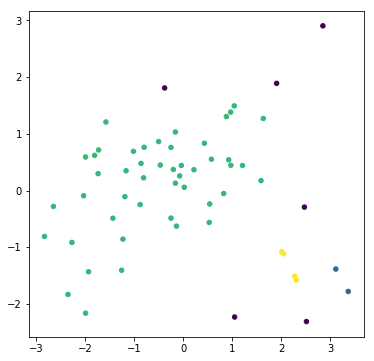

In [64]:
visuDB(SAH_pc,0.67,2)

Normal

In [306]:
# DBS_param(normal_pc)

In [70]:
max(silhouettescore) ## esp=0.64, min_samples=3

0.2712525611628011

Number of Cluster 2
Proportion of unclustered points= 0.2542372881355932


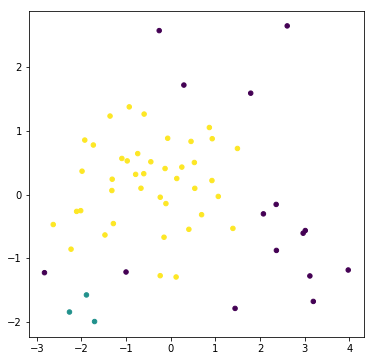

In [71]:
visuDB(normal_pc,0.64,3)

## K_Means

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

SAH

For n_clusters =2, the average silhouette_score is :0.4131734432161991
For n_clusters =3, the average silhouette_score is :0.42801038168003674
For n_clusters =4, the average silhouette_score is :0.40893678217483737
For n_clusters =5, the average silhouette_score is :0.40067245382766664
For n_clusters =6, the average silhouette_score is :0.3794600032887457
For n_clusters =7, the average silhouette_score is :0.35518693721730893
For n_clusters =8, the average silhouette_score is :0.3404403456540369
For n_clusters =9, the average silhouette_score is :0.37499536719537957
For n_clusters =10, the average silhouette_score is :0.3830885582409211
For n_clusters =11, the average silhouette_score is :0.31689100892273264
For n_clusters =12, the average silhouette_score is :0.3461649269626883
For n_clusters =13, the average silhouette_score is :0.3499067741629024
For n_clusters =14, the average silhouette_score is :0.36250259939861085
For n_clusters =15, the average silhouette_score is :0.3617166359

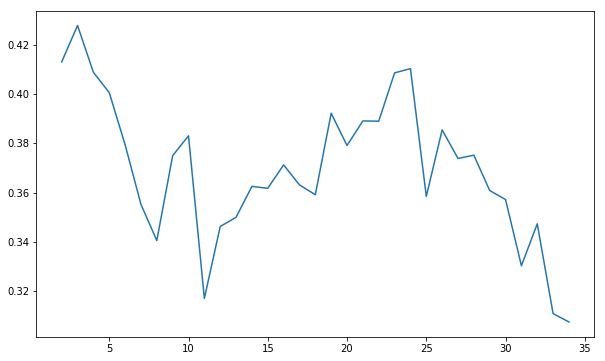

0.42801038168003674


In [73]:
def KM_param(data):
    silhouettescore = []
    for n_clusters in range(2,35): #try different numbers of clusters
        km = KMeans(n_clusters=n_clusters, random_state=324)
        cluster_labels = km.fit_predict(data)
        #report average Silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouettescore.append(silhouette_avg)
        print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

    plt.figure(figsize=(10,6))
    plt.plot(range(2,35),silhouettescore,linewidth=1.5,linestyle='-')
    plt.show()
    print(max(silhouettescore))
KM_param(SAH_pc)

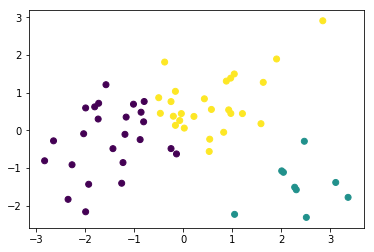

In [57]:
km = KMeans(n_clusters=3, random_state=324)
cluster_labels = km.fit_predict(SAH_pc)
plt.scatter(SAH_pc[:,0],SAH_pc[:,1],c=cluster_labels) #X population, Y income
plt.show()


Normal

For n_clusters =2, the average silhouette_score is :0.40590544198918976
For n_clusters =3, the average silhouette_score is :0.37020339144357434
For n_clusters =4, the average silhouette_score is :0.36675906139782954
For n_clusters =5, the average silhouette_score is :0.3838613009957267
For n_clusters =6, the average silhouette_score is :0.3561928279155894
For n_clusters =7, the average silhouette_score is :0.3557167152478653
For n_clusters =8, the average silhouette_score is :0.3626548389847279
For n_clusters =9, the average silhouette_score is :0.34488931272328827
For n_clusters =10, the average silhouette_score is :0.34436428024791554
For n_clusters =11, the average silhouette_score is :0.3160040481328031
For n_clusters =12, the average silhouette_score is :0.32774116289012467
For n_clusters =13, the average silhouette_score is :0.33067225938165973
For n_clusters =14, the average silhouette_score is :0.34424482174283527
For n_clusters =15, the average silhouette_score is :0.344071245

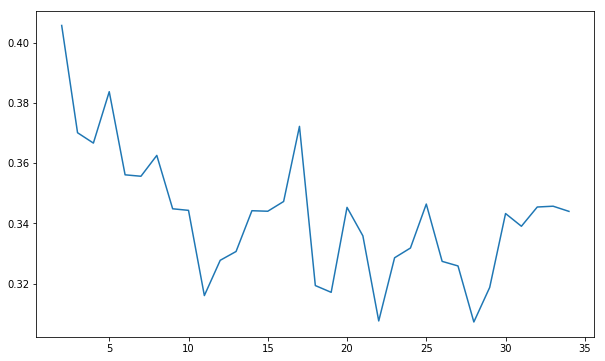

0.40590544198918976


In [74]:
KM_param(normal_pc)

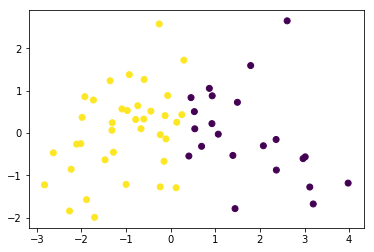

In [83]:
km = KMeans(n_clusters=2, random_state=324)
cluster_labels = km.fit_predict(normal_pc)
plt.scatter(normal_pc[:,0],normal_pc[:,1],c=cluster_labels) #X population, Y income
plt.show()

## Gussian Mixture

In [76]:
from sklearn.mixture import GaussianMixture

In [105]:
def GUS_param(data):
    silhouettescore = []
    for n_clusters in range(2,40): #try different numbers of clusters
        gmm = GaussianMixture(n_components=n_clusters,random_state=100)
        cluster_labels = gmm.fit_predict(data)
        #report average Silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouettescore.append(silhouette_avg)
        print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

    plt.figure(figsize=(10,6))
    plt.plot(range(2,40),silhouettescore,linewidth=1.5,linestyle='-')
    plt.show()
    print(max(silhouettescore))
    return (cluster_labels)

SAH

For n_clusters =2, the average silhouette_score is :0.4702026625987291
For n_clusters =3, the average silhouette_score is :0.39953580729625393
For n_clusters =4, the average silhouette_score is :0.39579515291203055
For n_clusters =5, the average silhouette_score is :0.3542644193933905
For n_clusters =6, the average silhouette_score is :0.32393413111899255
For n_clusters =7, the average silhouette_score is :0.28438155896584205
For n_clusters =8, the average silhouette_score is :0.3063734757364183
For n_clusters =9, the average silhouette_score is :0.28712190742078914
For n_clusters =10, the average silhouette_score is :0.2828226400646728
For n_clusters =11, the average silhouette_score is :0.2800797093355494
For n_clusters =12, the average silhouette_score is :0.33634317501425487
For n_clusters =13, the average silhouette_score is :0.3343469415972992
For n_clusters =14, the average silhouette_score is :0.33823844993315333
For n_clusters =15, the average silhouette_score is :0.3505816379

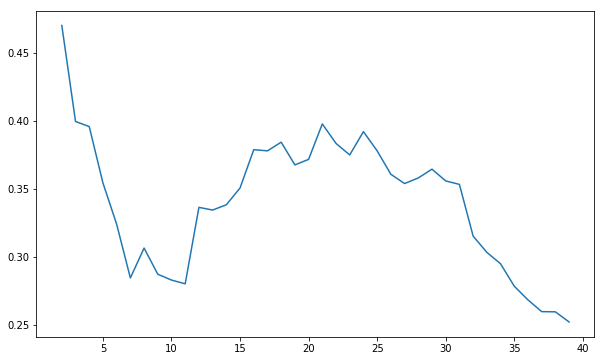

0.4702026625987291


array([34, 23, 10,  2,  2, 12, 18, 18,  0, 38, 33, 17, 30, 27, 36, 11, 11,
       11, 24, 32,  7,  8,  1, 31, 15, 19, 35, 37, 26,  6, 31,  1, 24, 16,
        1, 13, 25, 37, 28, 21,  3,  1, 32, 16, 35, 22,  5, 14, 31,  8, 28,
       15,  4, 20, 16, 17, 15, 29,  9])

In [103]:
GUS_param(SAH_pc)

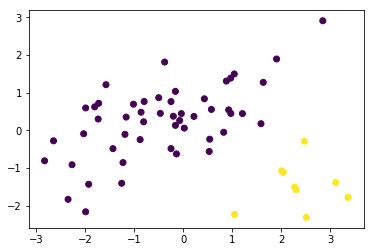

In [106]:
gmm = GaussianMixture(n_components=2,random_state=100)
cluster_labels = gmm.fit_predict(SAH_pc)
SAH_labels = cluster_labels
plt.scatter(SAH_pc[:,0],SAH_pc[:,1],c=cluster_labels) #X population, Y income
plt.show()

In [261]:
SAH_demo2 = SAH_demo
SAH_demo2['cluster_label'] = SAH_labels
SAH_demo2 = SAH_demo2.drop(columns=['avg_organic'])
SAH_demo2['avg_recyclable'] = SAH_demo2['avg_paper']+SAH_demo2['avg_mix']
cluster_0 = SAH_demo2.loc[SAH_demo2.cluster_label == 0]
cluster_1 = SAH_demo2.loc[SAH_demo2.cluster_label == 1]


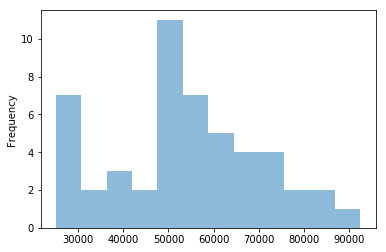

In [269]:
ax = cluster_0.HH_Income.plot.hist(bins=12, alpha=0.5, ylim=(0,11.5))

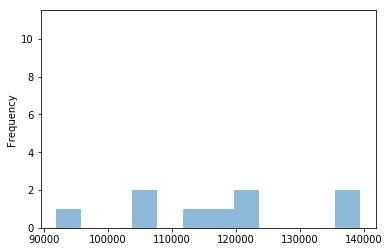

In [271]:
ax = cluster_1.HH_Income.plot.hist(bins=12, alpha=0.5,ylim=(0, 11.5))

In [157]:
from sklearn import linear_model
import statsmodels.formula.api as smf

Cluster 0 

In [247]:
x = cluster_0.values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
cluster_0_st = pd.DataFrame(x_scaled)
cluster_0_st.columns = ['Population', 'HH_Income', 'avg_refuse', 'avg_paper', 'avg_mix',
       'cluster_label', 'avg_recyclable']

lm_refuse0 = smf.ols(formula='avg_refuse ~ + HH_Income' , data = cluster_0_st).fit()
cluster_0_st['predicted_refuse'] = lm_refuse0.predict(cluster_0_st)

lm_recy0 = smf.ols(formula='avg_recyclable ~ + HH_Income' , data = cluster_0_st).fit()
cluster_0_st['predicted_recyclable'] = lm_recy0.predict(cluster_0_st)

Text(0.5, 1.0, 'cluster 0 Income vs. Refuse per capita')

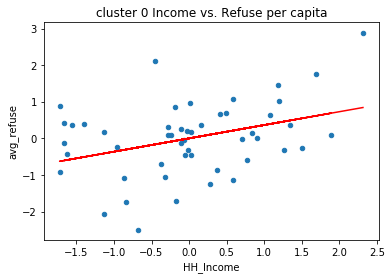

In [257]:
fig, ax = plt.subplots() #get axis to plot on
cluster_0_st.plot(ax=ax,kind='scatter',x='HH_Income',y='avg_refuse') #show the data
ax.plot(cluster_0_st.HH_Income,cluster_0_st.predicted_refuse,'r-')
plt.title("cluster 0 Income vs. Refuse per capita")

Text(0.5, 1.0, 'cluster 0 Income vs. Recyclable per capita')

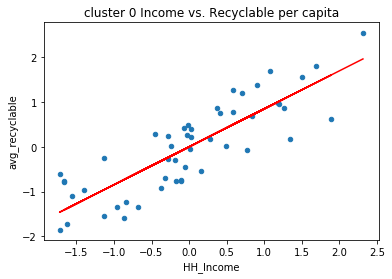

In [256]:
fig, ax = plt.subplots() #get axis to plot on
# ax.set_xscale('log'); ax.set_yscale('log') #set up log-scale for axis
cluster_0_st.plot(ax=ax,kind='scatter',x='HH_Income',y='avg_recyclable') #show the data
ax.plot(cluster_0_st.HH_Income,cluster_0_st.predicted_recyclable,'r-')
plt.title("cluster 0 Income vs. Recyclable per capita")

Cluster 1

In [244]:
x = cluster_1.values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
cluster_1_st = pd.DataFrame(x_scaled)
cluster_1_st.columns = ['Population', 'HH_Income', 'avg_refuse', 'avg_paper', 'avg_mix',
       'cluster_label', 'avg_recyclable']

lm_refuse = smf.ols(formula='avg_refuse ~ + HH_Income' , data = cluster_1_st).fit()
cluster_1_st['predicted_refuse'] = lm_refuse.predict(cluster_1_st)

lm_recy = smf.ols(formula='avg_recyclable ~ + HH_Income' , data = cluster_1_st).fit()
cluster_1_st['predicted_recyclable'] = lm_recy.predict(cluster_1_st)

Text(0.5, 1.0, 'cluster 1 Income vs. Refuse per capita')

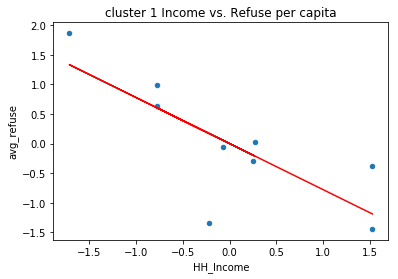

In [258]:
fig, ax = plt.subplots() #get axis to plot on
# ax.set_xscale('log'); ax.set_yscale('log') #set up log-scale for axis
cluster_1_st.plot(ax=ax,kind='scatter',x='HH_Income',y='avg_refuse') #show the data
ax.plot(cluster_1_st.HH_Income,cluster_1_st.predicted_refuse,'r-')
plt.title("cluster 1 Income vs. Refuse per capita")

Text(0.5, 1.0, 'cluster 1 Income vs. Recyclable per capita')

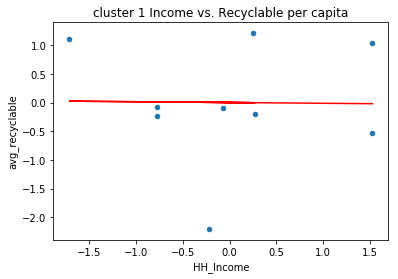

In [259]:
fig, ax = plt.subplots() #get axis to plot on
cluster_1_st.plot(ax=ax,kind='scatter',x='HH_Income',y='avg_recyclable') #show the data
ax.plot(cluster_1_st.HH_Income,cluster_1_st.predicted_recyclable,'r-')
plt.title("cluster 1 Income vs. Recyclable per capita")

Normal

For n_clusters =2, the average silhouette_score is :0.3988411509846394
For n_clusters =3, the average silhouette_score is :0.32586448944203206
For n_clusters =4, the average silhouette_score is :0.3128029381383465
For n_clusters =5, the average silhouette_score is :0.3703118217207944
For n_clusters =6, the average silhouette_score is :0.36184387603603746
For n_clusters =7, the average silhouette_score is :0.28116757333251263
For n_clusters =8, the average silhouette_score is :0.2738974886875229
For n_clusters =9, the average silhouette_score is :0.3072722115656318
For n_clusters =10, the average silhouette_score is :0.28702797639502553
For n_clusters =11, the average silhouette_score is :0.2692469989995263
For n_clusters =12, the average silhouette_score is :0.2525991244299893
For n_clusters =13, the average silhouette_score is :0.2599695060127222
For n_clusters =14, the average silhouette_score is :0.24621683252107363
For n_clusters =15, the average silhouette_score is :0.242883497552

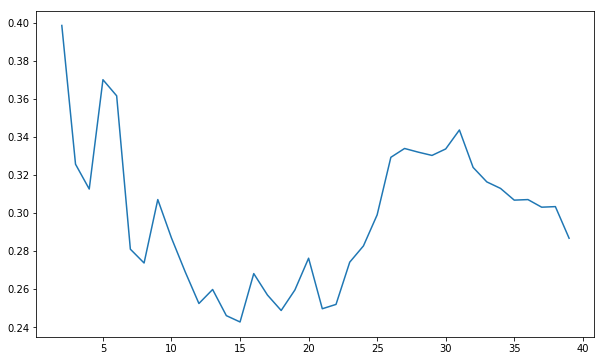

0.3988411509846394


In [84]:
GUS_param(normal_pc)

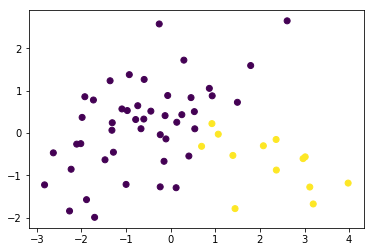

In [260]:
gmm = GaussianMixture(n_components=2,random_state=100)
cluster_labels = gmm.fit_predict(normal_pc)
normal_labels = cluster_labels
plt.scatter(normal_pc[:,0],normal_pc[:,1],c=cluster_labels) #X population, Y income
plt.show()

In [265]:
waste_demo2 = waste_demo
waste_demo2['cluster_label'] = normal_labels
waste_demo2 = waste_demo2.drop(columns=['avg_organic'])
waste_demo2['avg_recyclable'] = waste_demo2['avg_paper']+waste_demo2['avg_mix']
cluster_0_n = waste_demo2.loc[waste_demo2.cluster_label == 0]
cluster_1_n = waste_demo2.loc[waste_demo2.cluster_label == 1]

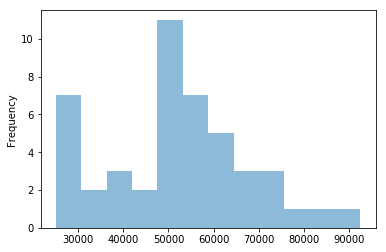

In [272]:
ax = cluster_0_n.HH_Income.plot.hist(bins=12, alpha=0.5, ylim=(0,11.5))

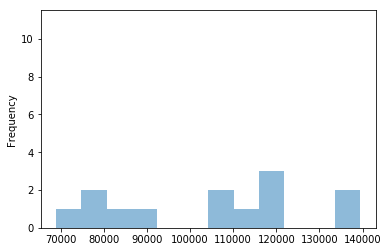

In [273]:
ax = cluster_1_n.HH_Income.plot.hist(bins=12, alpha=0.5,ylim=(0,11.5))

Cluster 0 Normal Time

In [277]:
x = cluster_0_n.values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
cluster_0_n_st = pd.DataFrame(x_scaled)
cluster_0_n_st.columns = ['Population', 'HH_Income', 'avg_refuse', 'avg_paper', 'avg_mix',
       'cluster_label', 'avg_recyclable']

lm_refuse0_n = smf.ols(formula='avg_refuse ~ + HH_Income' , data = cluster_0_n_st).fit()
cluster_0_n_st['predicted_refuse'] = lm_refuse0.predict(cluster_0_n_st)

lm_recy0_n = smf.ols(formula='avg_recyclable ~ + HH_Income' , data = cluster_0_n_st).fit()
cluster_0_n_st['predicted_recyclable'] = lm_recy0.predict(cluster_0_n_st)

Text(0.5, 1.0, 'cluster 0 Income vs. Refuse per capita')

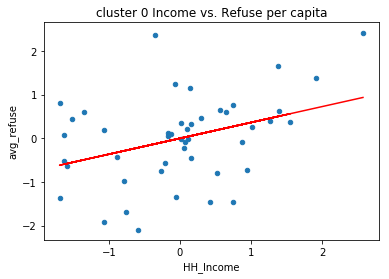

In [279]:
fig, ax = plt.subplots() #get axis to plot on
cluster_0_n_st.plot(ax=ax,kind='scatter',x='HH_Income',y='avg_refuse') #show the data
ax.plot(cluster_0_n_st.HH_Income,cluster_0_n_st.predicted_refuse,'r-')
plt.title("cluster 0 Income vs. Refuse per capita")

Text(0.5, 1.0, 'cluster 0 Income vs. Recyclable per capita')

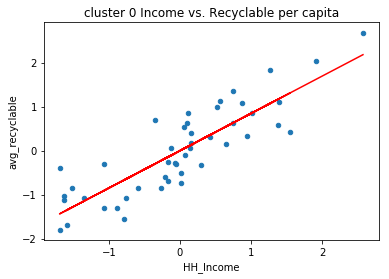

In [280]:
fig, ax = plt.subplots() #get axis to plot on
# ax.set_xscale('log'); ax.set_yscale('log') #set up log-scale for axis
cluster_0_n_st.plot(ax=ax,kind='scatter',x='HH_Income',y='avg_recyclable') #show the data
ax.plot(cluster_0_n_st.HH_Income,cluster_0_n_st.predicted_recyclable,'r-')
plt.title("cluster 0 Income vs. Recyclable per capita")

Cluster 1 Normal Time

In [282]:
x = cluster_1_n.values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
cluster_1_n_st = pd.DataFrame(x_scaled)
cluster_1_n_st.columns = ['Population', 'HH_Income', 'avg_refuse', 'avg_paper', 'avg_mix',
       'cluster_label', 'avg_recyclable']

lm_refuse_n = smf.ols(formula='avg_refuse ~ + HH_Income' , data = cluster_1_n_st).fit()
cluster_1_n_st['predicted_refuse'] = lm_refuse_n.predict(cluster_1_n_st)

lm_recy_n = smf.ols(formula='avg_recyclable ~ + HH_Income' , data = cluster_1_n_st).fit()
cluster_1_n_st['predicted_recyclable'] = lm_recy_n.predict(cluster_1_n_st)

Text(0.5, 1.0, 'cluster 1 Income vs. Refuse per capita')

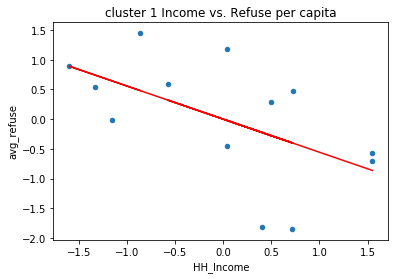

In [283]:
fig, ax = plt.subplots() #get axis to plot on
# ax.set_xscale('log'); ax.set_yscale('log') #set up log-scale for axis
cluster_1_n_st.plot(ax=ax,kind='scatter',x='HH_Income',y='avg_refuse') #show the data
ax.plot(cluster_1_n_st.HH_Income,cluster_1_n_st.predicted_refuse,'r-')
plt.title("cluster 1 Income vs. Refuse per capita")

Text(0.5, 1.0, 'cluster 1 Income vs. Recyclable per capita')

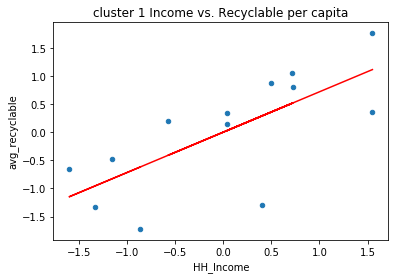

In [284]:
fig, ax = plt.subplots() #get axis to plot on
cluster_1_n_st.plot(ax=ax,kind='scatter',x='HH_Income',y='avg_recyclable') #show the data
ax.plot(cluster_1_n_st.HH_Income,cluster_1_n_st.predicted_recyclable,'r-')
plt.title("cluster 1 Income vs. Recyclable per capita")

In [285]:
y20_pan.sum()

REFUSETONSCOLLECTED    396609.4
PAPERTONSCOLLECTED      47122.9
MGPTONSCOLLECTED        54953.4
RESORGANICSTONS          4447.3
dtype: float64

In [286]:
pan_normal.sum()

REFUSETONSCOLLECTED    406944.78
PAPERTONSCOLLECTED      47982.38
MGPTONSCOLLECTED        45250.94
RESORGANICSTONS          2708.74
dtype: float64

In [293]:
nycd=gpd.read_file('nycd_19d/nycd.shp')
nycd_heat = nycd.copy()

SAH

In [300]:
label = SAH_demo2.cluster_label.to_dict()
label = {int(k):int(v) for k,v in label.items()}
nycd_heat['CD_cluster_SAH']=nycd_heat.BoroCD.map(label)
nycd_heat.dropna(inplace=True)

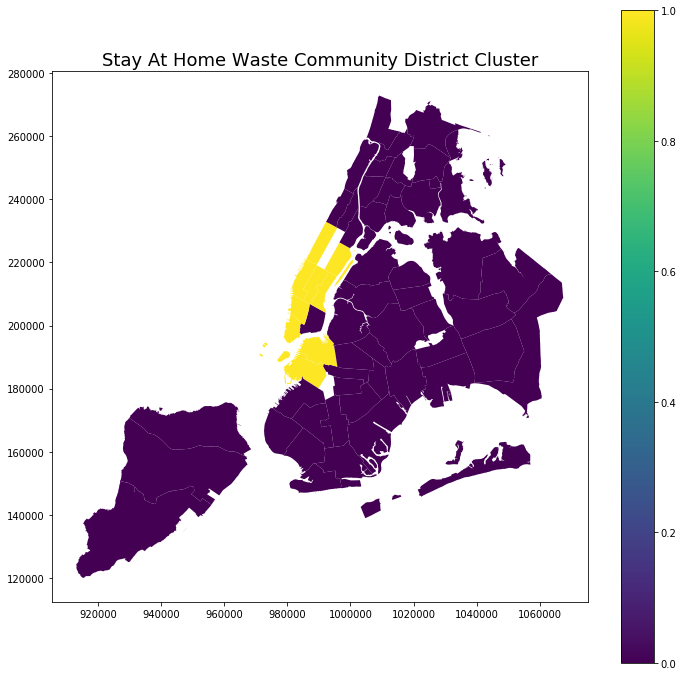

In [305]:
f, ax = plt.subplots(1,1, figsize=(12, 12))
ax.set_title("Stay At Home Waste Community District Cluster", fontsize=18)
nycd_heat.plot(ax=ax, column='CD_cluster_SAH', legend = True, cmap=plt.cm.get_cmap('viridis'))

Normal Time

In [302]:
label_n = waste_demo2.cluster_label.to_dict()
label_n = {int(k):int(v) for k,v in label_n.items()}
nycd_heat['CD_cluster_normal']=nycd_heat.BoroCD.map(label_n)

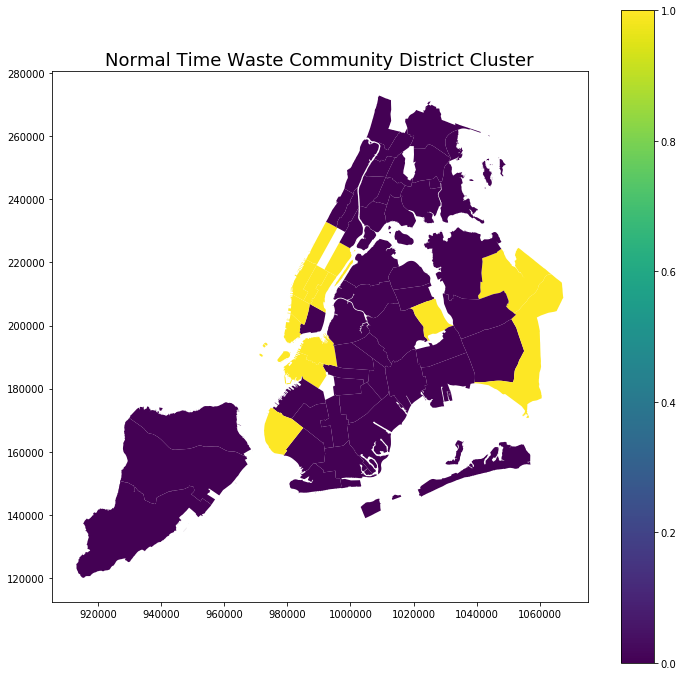

In [304]:
f, ax = plt.subplots(1,1, figsize=(12, 12))
ax.set_title("Normal Time Waste Community District Cluster", fontsize=18)
nycd_heat.plot(ax=ax, column='CD_cluster_normal', legend = True, cmap=plt.cm.get_cmap('viridis'))

Community District Income

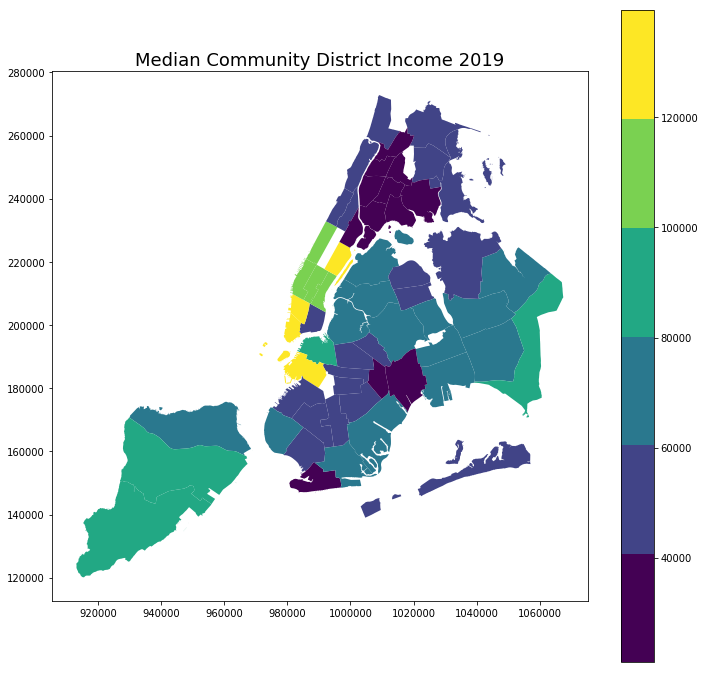

In [317]:
Income = demo_small.HH_Income.to_dict()
Income = {int(k):int(v) for k,v in Income.items()}
nycd_heat['Income']=nycd_heat.BoroCD.map(Income)
f, ax = plt.subplots(1,1, figsize=(12, 12))
ax.set_title("Median Community District Income 2019", fontsize=18)
nycd_heat.plot(ax=ax, column='Income', legend = True, cmap=plt.cm.get_cmap('viridis',6),vmin=21000)